#SEMINAR 2: KLASIFIKACIJA ALZHEIMEROVE BOELSTTI

Mateja Vuradin

## 1. Import knjižnica

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


## 2. Priprema podataka

Korišteni su javno dostupni [podaci](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data), tj. 6400 predprocesiranih MR slika. Slike su podjeljene u 4 klase:
*   nedementni
*   vrlo blago dementni
* blago dementni
*srednje dementni

Sve slike su veličine 128x128.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Dataset/"

In [ ]:
matplotlib.rcdefaults()

There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.


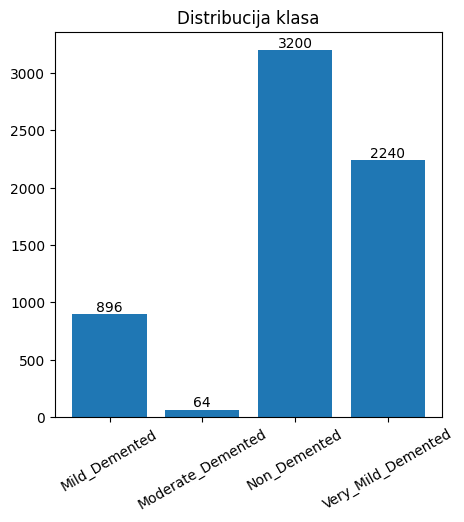

In [ ]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    image_extensions = ['.jpg']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    plt.figure(figsize=(5,5))
    plt.bar(keys, values)
    for i, value in enumerate(values):
      plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
    plt.xticks(rotation=30)
    plt.title('Distribucija klasa')

image_counter(base_dir)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


Mild_Demented Brain MRI Samples


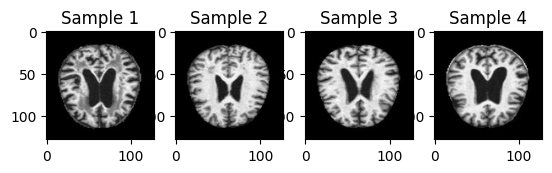

Moderate_Demented Brain MRI Samples


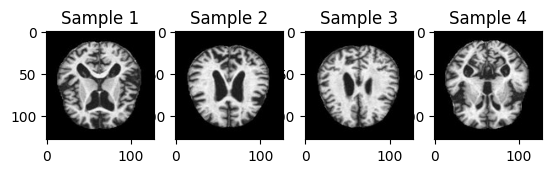

Non_Demented Brain MRI Samples


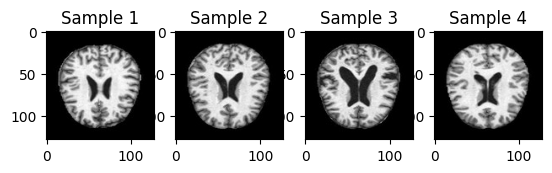

Very_Mild_Demented Brain MRI Samples


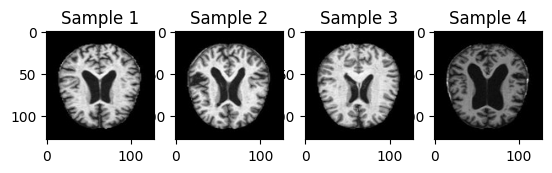

In [ ]:
def sample_bringer(path, target):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path)]

    print(f'{target} Brain MRI Samples')

    for i in range(4):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        plt.subplot(1,4, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Sample {i+1}')
    plt.show()

for target in class_names:
    sample_bringer(base_dir, target=target)

Normalizacija pixela iz 0-255 u 0-1:

In [ ]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class DataClass:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()

    def show_batch_images(self):
        print("Samples in the Batch")
        plt.figure(figsize=(20,5))
        for idx, img in enumerate(self.batch[0][:5]):
            plt.subplot(1,5,idx+1)
            plt.imshow(img)
            class_no = self.batch[1][idx]
            plt.title(alz_dict[class_no])

    def train_test_val_split(self, train_size, val_size, test_size):
        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Samples in the Batch


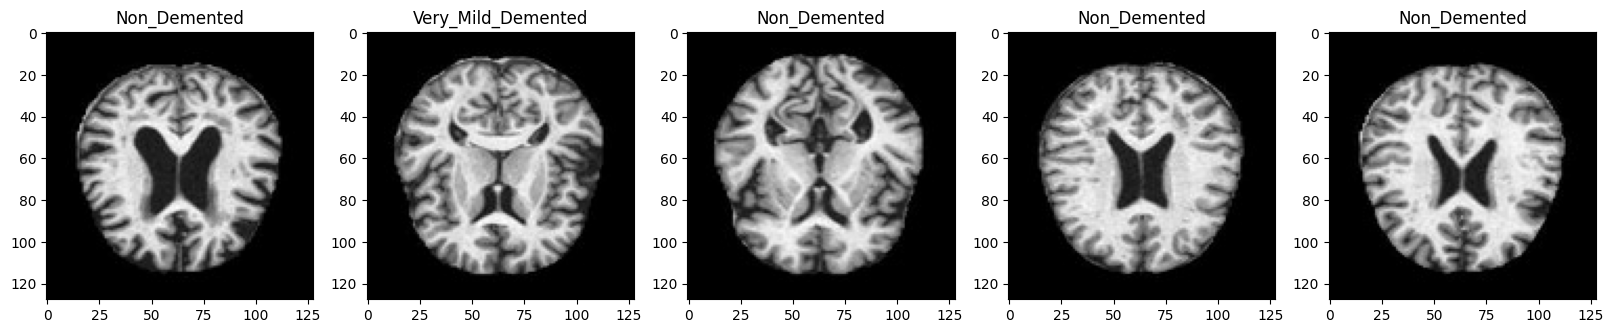

In [ ]:
dataCl = DataClass(data)
dataCl.create_new_batch()
dataCl.show_batch_images()

In [ ]:
train_data, val_data, test_data= dataCl.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

Zbog nebalansiranosti klasa, koristiti ćemo težinu klasa koju ćemo uzeti u obzir kod treniranja.

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [ ]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
160/160 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.3592
Epoch 1: val_accuracy improved from -inf to 0.02031, saving model to /tmp/checkpoint
160/160 [==============================] - 241s 1s/step - loss: 1.4544 - accuracy: 0.3592 - val_loss: 2.1506 - val_accuracy: 0.0203
Epoch 2/20
160/160 [==============================] - ETA: 0s - loss: 1.1822 - accuracy: 0.4867
Epoch 2: val_accuracy improved from 0.02031 to 0.64375, saving model to /tmp/checkpoint
160/160 [==============================] - 118s 731ms/step - loss: 1.1822 - accuracy: 0.4867 - val_loss: 0.8777 - val_accuracy: 0.6438
Epoch 3/20
160/160 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6531
Epoch 3: val_accuracy did not improve from 0.64375
160/160 [==============================] - 115s 712ms/step - loss: 0.6173 - accuracy: 0.6531 - val_loss: 0.8822 - val_accuracy: 0.6141
Epoch 4/20
160/160 [==============================] - ETA: 0s - loss: 0.2850 - accurac

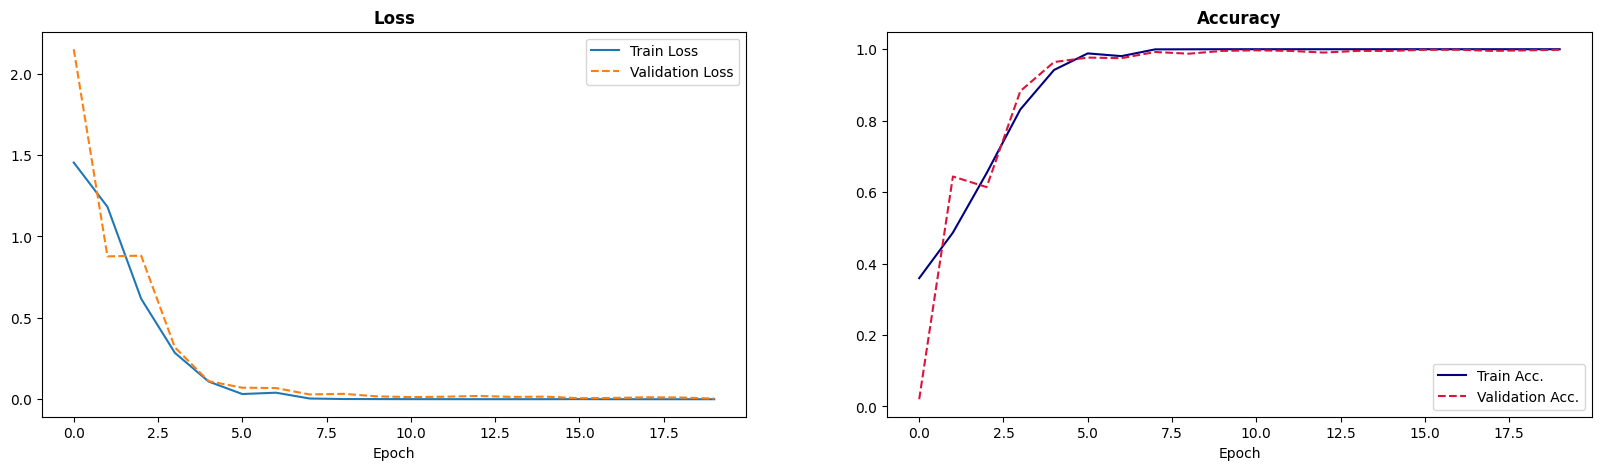

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history["loss"], label="Train Loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss", linestyle="dashed")
plt.title('Loss', fontweight="bold")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1,2,2)
plt.title('Accuracy', fontweight="bold")
plt.xlabel("Epoch")
plt.plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
plt.legend()

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 62s 2s/step - loss: 0.0298 - accuracy: 0.9906


[0.029799873009324074, 0.9906250238418579]

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.96      0.98        83
 Moderate_Demented       1.00      1.00      1.00         5
      Non_Demented       0.99      1.00      0.99       319
Very_Mild_Demented       0.99      0.99      0.99       233

          accuracy                           0.99       640
         macro avg       0.99      0.99      0.99       640
      weighted avg       0.99      0.99      0.99       640



Text(95.5815972222222, 0.5, 'True')

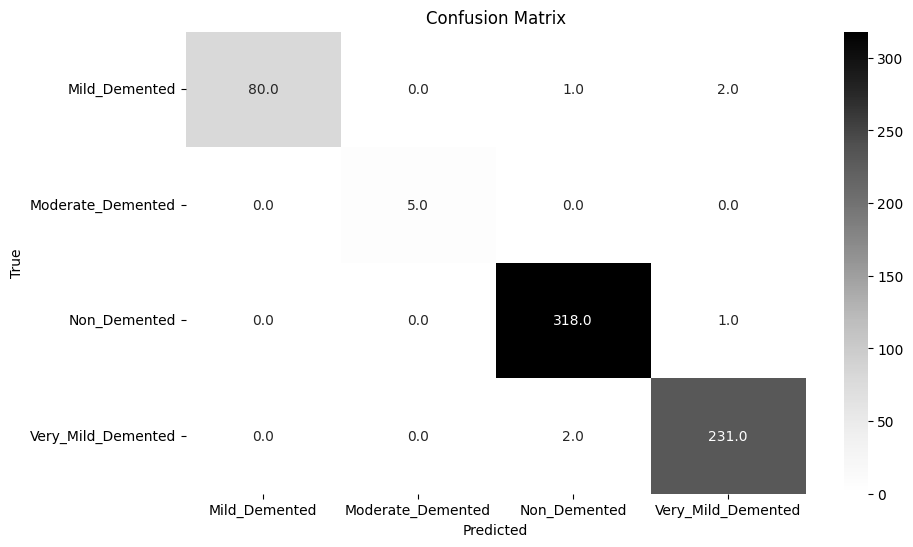

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")